# Delay experiment
how does delay time affect training?
- 2 orthogonal stimuli
- reward: +1 hold +1 final action 0 otherwise

In [1]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')

from utils import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [2]:
# single condition of experiment
def exp(stimvar,neps,nseeds):
  task = PWMTask(
    stim_set=[(0,1),(1,0)],
    embed_stim='gauss',
    stim_mean=[-1,1],
    stim_var=stimvar
  )
  reward = np.zeros([nseeds,neps])
  for s in range(nseeds):
    actor = ActorCritic()
    env = Env(actor,task)
    for ep in range(neps):
      data = env.run_pwm_trial2(update=True)
      reward[s,ep]=data['reward'][-1]
  return reward


In [3]:
# run experiment over stimvar conditions
nseeds,neps=15,5000
L = []
varL = [0,0.001,0.005]
for var in varL:
  print(var)
  R = exp(var,neps,nseeds)
  L.append(R)
results = np.array(L)

0
0.001
0.005


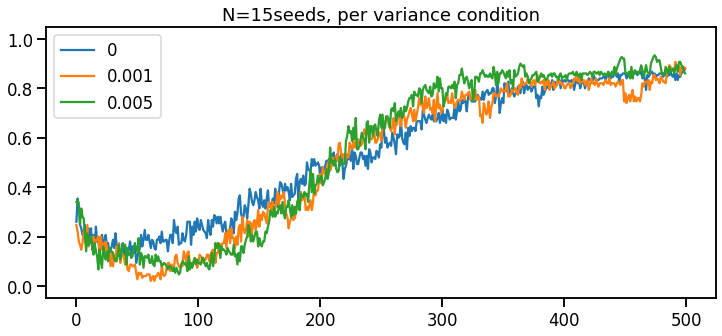

In [12]:
plt.figure(figsize=(12,5))
for d,res in zip(varL,results):
  M = res.mean(0) 
  S = res.std(0) / np.sqrt(len(res))
  M = M.reshape(-1,10).mean(1)
  plt.plot(M,label=d)
plt.title('N=%iseeds, per variance condition'%nseeds)
plt.ylim(-.05,1.05)
plt.legend()
plt.savefig('figures/stimvar-aux1')